# Isopycnal heaving and along isopycnal change decomposition
This notebook is to show how we can decompose temperature (or other scalar) anomalies into isopycnal heaving and changes along isopycnals (water mass transformation)



In [1]:
# load modules
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
from dask.distributed import Client
import matplotlib.path as mpath
import cartopy.feature as cft
import xgcm
from xgcm import Grid
import gsw
from xhistogram.xarray import histogram
import intake

In [2]:
#Start a cluster with multiple cores
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33655,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40009,Total threads: 1
Dashboard: /proxy/36251/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:44263,


## Step 1: Load dataset
To calculate the temperature change along the isopycnal, we will need both temperature(x,y,depth) and density(x,y,depth), to get tempertaure(x,y,density).

In [3]:
catalog = intake.cat.access_nri
experiment_Control = '01deg_jra55v13_ryf9091' # Control experiment
experiment_Pertubation = '01deg_jra55v13_ryf9091_qian_wthp' # Perturbation experiment

In [4]:
# Load Control conservative temperature and practical salinity
temp_ctrl = catalog[experiment_Control].search(variable="temp").to_dataset_dict() 
temp_ctrl=temp_ctrl["ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.neutral:80.neutralrho_edges:81.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700"]["temp"]

salt_ctrl = catalog[experiment_Control].search(variable="salt").to_dataset_dict() 
salt_ctrl=salt_ctrl["ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.neutral:80.neutralrho_edges:81.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700"]["salt"]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id'


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id'


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

In [5]:
# Load Perturbation conservative temperature and practical salinity
temp_pert = catalog[experiment_Pertubation].search(variable="temp").to_dataset_dict() 
temp_pert=temp_pert["ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700"]["temp"]

salt_pert = catalog[experiment_Pertubation].search(variable="salt").to_dataset_dict()
salt_pert=salt_pert["ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700"]["salt"]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id'


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id'


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Step 2: Get the potential density by using gsw

In [6]:
# The time period you want to look at
start_time = '2150-01-01'
end_time = '2150-12-31'

# the domain you want to look at
lat_slice = slice(-90,-50)
lon = -130

In [7]:
# function to select the time period and domain you want for your variables
def var_domain(var):
    var_domain = var.sel(time = slice(start_time,end_time)).sel(xt_ocean = lon, method = 'nearest').sel(yt_ocean = lat_slice).mean('time').load()

    return var_domain

In [8]:
# output for temporal averaged variables in the Southern Ocean
temp_SO_ctrl = var_domain(temp_ctrl)
salt_SO_ctrl = var_domain(salt_ctrl)

temp_SO_pert = var_domain(temp_pert)
salt_SO_pert = var_domain(salt_pert)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 70.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 70.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/cli

In [9]:
# Use temperature and salinity to get the potential density you want, here I use the potential density referenced to 1000 m depth.
depth_rho = 1000 

def pot_rho(temp,salt):
    # practical salinity to absolute salinity
    salt_ab = gsw.conversions.SA_from_SP(salt, salt.st_ocean, salt.xt_ocean, salt.yt_ocean)
    
    # transfer to potential density you want
    rho = gsw.density.rho(salt_ab, temp-273.15, depth_rho)
    

    return rho

In [10]:
# get the density variables
rho_SO_ctrl = pot_rho(temp_SO_ctrl,salt_SO_ctrl)
rho_SO_pert = pot_rho(temp_SO_pert,salt_SO_pert)

## Step 3: Calculate the temperature change along the isopycnal by using xgcm, and the residual is the temperature change due to isopycnal heaving.

First you need a isoopycnal bin to transfer from temp(y,depth) to temp(y,density).

In [23]:
# Create your isopycnal bins, to reduce your computing time, they could be non-linear.
bin1 = np.arange(1020, 1025, 0.1)
bin2 = np.arange(1025, 1035, 0.02)
# Concatenate the two non-linear bins
isopycnal_bins = np.concatenate((bin1, bin2))

Also, to transfer isopycnal temperature changes temp_anomaly(y,density) back to temp_anomaly(y,depth), we will need a depth grid depth(x,y,z).

In [12]:
# the depth and lat coordinate in the model
st_ocean = temp_SO_ctrl.st_ocean.values
yt_ocean = temp_SO_ctrl.yt_ocean.values
# get the depth(y,depth)
depth = np.zeros((len(st_ocean),len(yt_ocean)))
for j in range(len(yt_ocean)):
    depth[:,j] = st_ocean

depth = xr.DataArray(depth, dims = ['st_ocean','yt_ocean'], coords = [temp_SO_ctrl.st_ocean, temp_SO_ctrl.yt_ocean])

Now all good to go. Let's calculate the temperature change along the isopycnal by using gsw. And the residual (total temperature change minus temperature change along the isopycnal) is the isopycnal heaving part.

In [24]:
# Function to calculate the temperature change along the isopycnal
def isopycnal_temp_change(var_ctrl, var_pert, rho_ctrl, rho_pert):
    # get the grid dataset you want to transfer
    ds_ctrl = xr.Dataset({'var_ctrl': var_ctrl, 'rho_ctrl': rho_ctrl})
    ds_pert = xr.Dataset({'var_pert': var_pert, 'rho_pert': rho_pert})
    ds_ctrl.coords['st_ocean'].attrs.update(axis='Z')
    ds_ctrl.coords['yt_ocean'].attrs.update(axis='Y')
    ds_pert.coords['st_ocean'].attrs.update(axis='Z')
    ds_pert.coords['yt_ocean'].attrs.update(axis='Y')
    grid_ctrl = Grid(ds_ctrl, periodic=False)
    grid_pert = Grid(ds_pert, periodic=False)
    # transfer vars from depth coord to isopycnal bins
    var_ctrl_rho = grid_ctrl.transform(ds_ctrl.var_ctrl, 'Z', isopycnal_bins, target_data=ds_ctrl.rho_ctrl,method='linear')
    var_ctrl_rho = var_ctrl_rho.rename({'rho_ctrl': 'pot_rho_1'})
    var_pert_rho = grid_pert.transform(ds_pert.var_pert, 'Z', isopycnal_bins, target_data=ds_pert.rho_pert,method='linear')
    var_pert_rho = var_pert_rho.rename({'rho_pert': 'pot_rho_1'})
    # Create depth(t,pot_rho,y), here we use the averaged density field between two experiments
    ds_depth = xr.Dataset({'pot_rho_1': (rho_ctrl+rho_pert)/2, 'depth': depth})
    ds_depth.coords['st_ocean'].attrs.update(axis='Z')
    ds_depth.coords['yt_ocean'].attrs.update(axis='Y')
    grid = Grid(ds_depth, periodic=False)
    depth_rho = grid.transform(ds_depth.depth, 'Z', isopycnal_bins, target_data=ds_depth.pot_rho_1,method='linear')
    # Compute the anomaly in density coords, then transfer anomaly back to depth coords
    var_ano_rho = var_pert_rho-var_ctrl_rho
    ds_ano = xr.Dataset({'depth': depth_rho, 'var_ano': var_ano_rho})
    ds_ano.coords['yt_ocean'].attrs.update(axis='Y')
    ds_ano.coords['pot_rho_1'].attrs.update(axis='Pot_rho_1')
    grid = Grid(ds_ano, periodic=False)
    depth_bin = np.concatenate((np.arange(0,200.,0.02), np.arange(200.,6000.,10.)))
    var_ano_depth = grid.transform(ds_ano.var_ano, 'Pot_rho_1', depth_bin, target_data=ds_ano.depth,method='linear')
    # Make the coordinates and dimensions in the new anomaly consistent to the total anomaly
    var_ano_depth = var_ano_depth.transpose('depth','yt_ocean')
    var_ano_depth = var_ano_depth.interp(depth = st_ocean, method = 'linear')
    var_ano_depth = var_ano_depth.rename({'depth':'st_ocean'})

    return [var_ctrl_rho,var_pert_rho,var_ano_rho,var_ano_depth,depth_rho] 

In [25]:
# get the values
temp_ctrl_rho,temp_pert_rho,temp_ano_rho,temp_ano_depth,depth_rho = isopycnal_temp_change(temp_SO_ctrl, temp_SO_pert, rho_SO_ctrl, rho_SO_pert)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numba/np/ufunc/gufunc.py:261: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numba/np/ufunc/gufunc.py:261: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numba/np/ufunc/gufunc.py:261: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


## Step 4: Plot the total temperature change, temperature change along the isopycnal and temperature change due to heaving. 

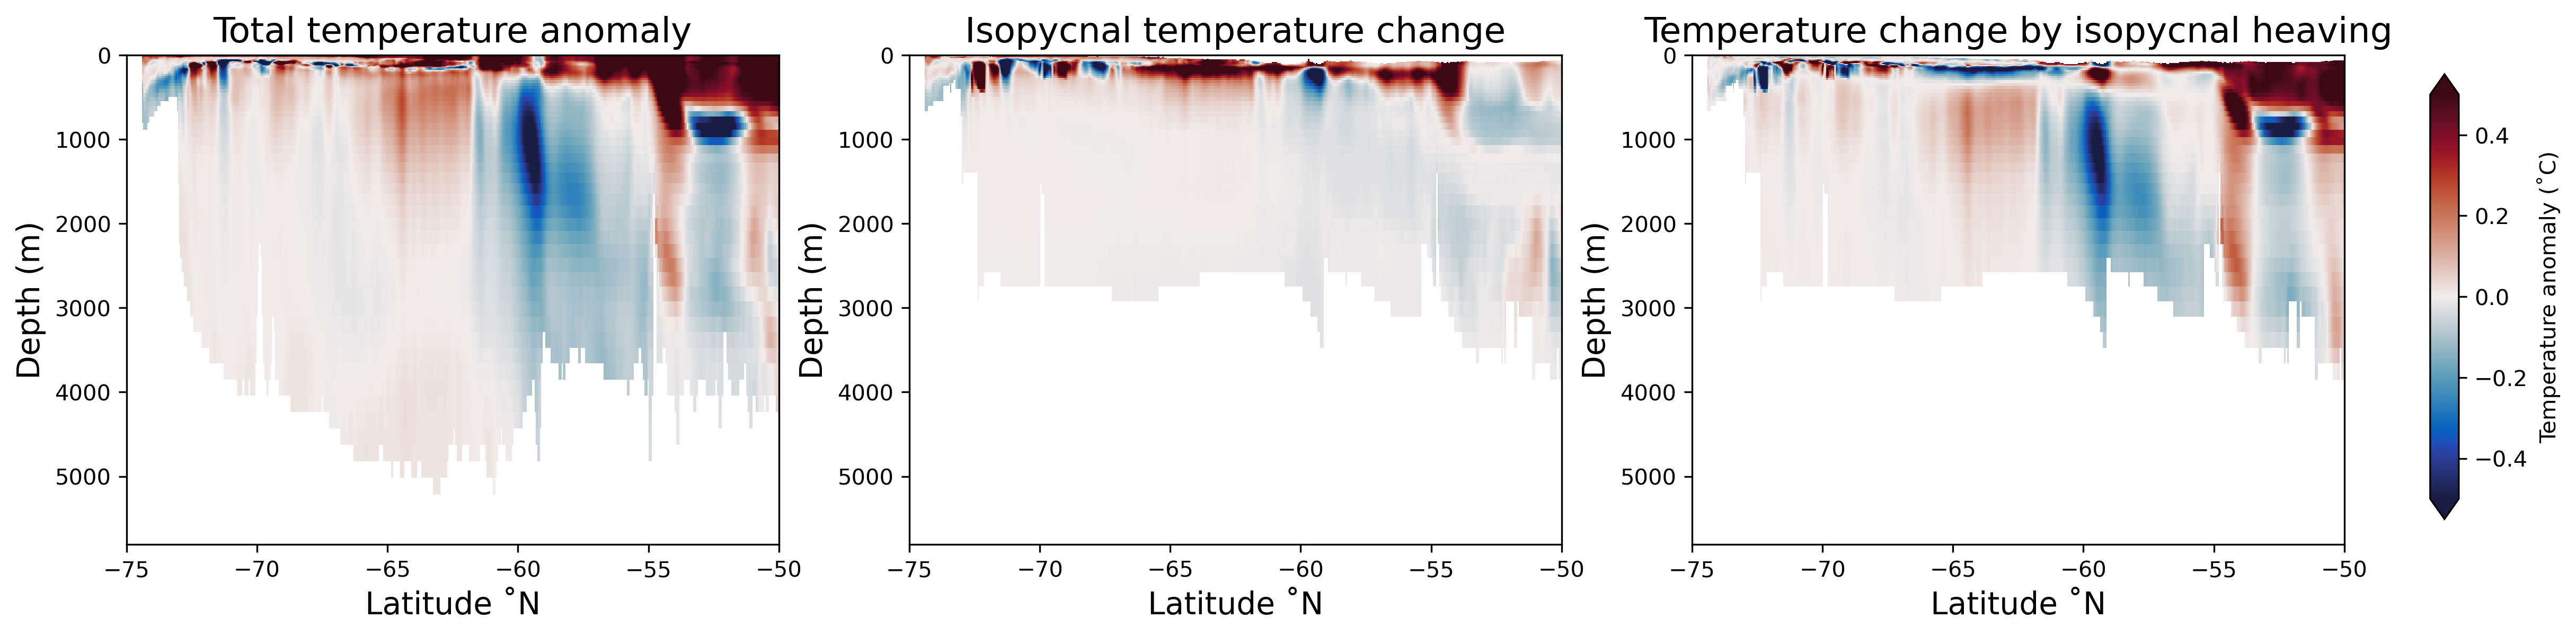

In [33]:
fig = plt.figure(figsize=(18,4),dpi = 300)

ax = plt.subplot(1,3,1)

p1 = (temp_SO_pert-temp_SO_ctrl).plot(vmin=-0.5,vmax=0.5, cmap = cm.cm.balance,add_colorbar = False)
plt.gca().invert_yaxis()
plt.xlim(-75,-50)
plt.xlabel('Latitude ˚N',fontsize = 14)
plt.ylabel('Depth (m)',fontsize = 14)
ax.set_title('Total temperature anomaly',fontsize = 16)

ax = plt.subplot(1,3,2)
p1 = (temp_ano_depth).plot(vmin=-0.5,vmax=0.5, cmap = cm.cm.balance,add_colorbar = False)
plt.gca().invert_yaxis()
plt.xlim(-75,-50)
plt.xlabel('Latitude ˚N',fontsize = 14)
plt.ylabel('Depth (m)',fontsize = 14)
ax.set_title('Isopycnal temperature change',fontsize = 16)

ax = plt.subplot(1,3,3)
p1 = (temp_SO_pert-temp_SO_ctrl-temp_ano_depth).plot(vmin=-0.5,vmax=0.5, cmap = cm.cm.balance,add_colorbar = False)
plt.gca().invert_yaxis()
plt.xlim(-75,-50)
plt.xlabel('Latitude ˚N',fontsize = 14)
plt.ylabel('Depth (m)',fontsize = 14)
ax.set_title('Temperature change by isopycnal heaving',fontsize = 16)

ax_cb1 = plt.axes([0.93, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax=ax_cb1,  orientation='vertical',extend='both')
cb.ax.set_ylabel('Temperature anomaly (˚C)')
cb.ax.yaxis.set_label_position('right')
cb.ax.yaxis.set_ticks_position('right')